In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [2]:
dataset_orig = pd.read_csv('../../../data/processed.cleveland.data.csv')

## Drop categorical features
## Drop NULL values
dataset_orig = dataset_orig.dropna()


## calculate mean of age column
mean = dataset_orig.loc[:,"age"].mean()
dataset_orig['age'] = np.where(dataset_orig['age'] >= mean, 0, 1)

## Make goal column binary
dataset_orig['Probability'] = np.where(dataset_orig['Probability'] > 0, 1, 0)

protected_attribute = 'age'

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset_orig = pd.DataFrame(scaler.fit_transform(dataset_orig),columns = dataset_orig.columns)

(dataset_orig.head(5))

   age  sex        cp  trestbps      chol  fbs  restecg   thalach  exang  \
0  1.0  1.0  0.000000  0.481132  0.244292  1.0      1.0  0.603053    0.0   
1  1.0  1.0  1.000000  0.622642  0.365297  0.0      1.0  0.282443    1.0   
2  1.0  1.0  1.000000  0.245283  0.235160  0.0      1.0  0.442748    1.0   
3  0.0  1.0  0.666667  0.339623  0.283105  0.0      0.0  0.885496    0.0   
4  0.0  0.0  0.333333  0.339623  0.178082  0.0      1.0  0.770992    0.0   

    oldpeak  slope        ca  thal  Probability  
0  0.370968    1.0  0.000000  0.75          0.0  
1  0.241935    0.5  1.000000  0.00          1.0  
2  0.419355    0.5  0.666667  1.00          1.0  
3  0.564516    1.0  0.000000  0.00          0.0  
4  0.225806    0.0  0.000000  0.00          0.0  


In [3]:
# This dataset size is very small. So repeating it to make it bigger

dataset_orig = pd.concat([dataset_orig]*5, ignore_index=True)

# Transform data using Reweighing¶

In [4]:
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.datasets import BinaryLabelDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy

dataset_orig_train,dataset_orig_test = train_test_split(dataset_orig,test_size=0.2,random_state=0)

protected_attribute = "race"
dataset = BinaryLabelDataset(df=dataset_orig_train, label_names=['Probability'], protected_attribute_names=[protected_attribute])

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
privileged_groups = [{protected_attribute: 1}]
unprivileged_groups = [{protected_attribute: 0}]
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)
dataset_orig_train, weights = dataset_transf.convert_to_dataframe()

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train,sample_weight=weights['instance_weights'])

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Probability
0,1.0,1.0,0.0,0.481132,0.244292,1.0,1.0,0.603053,0.0,0.370968,1.0,0.000000,0.75,0.0
1,1.0,1.0,1.0,0.622642,0.365297,0.0,1.0,0.282443,1.0,0.241935,0.5,1.000000,0.00,1.0
2,1.0,1.0,1.0,0.245283,0.235160,0.0,1.0,0.442748,1.0,0.419355,0.5,0.666667,1.00,1.0


In [5]:
index = 0
df = dataset_orig_train.copy()
for i,row in df.iterrows():
    duplicate = round(weights["instance_weights"][int(index)])*10
    for j in range(int(duplicate)):
        df = df.append(row)
    index += 1
print(df.shape)

(18435, 14)


# Grpah

In [12]:
causal_graph = """
digraph {
age;
thalach;
cp;
thal;
sex;
exang;
Probability;
U[label="Unobserved Confounders"];
sex -> Probability;
age -> thalch; thalch -> Probability;
age -> cp; cp -> Probability
age -> exang; exang -> Probability;
thal -> Probability;
age -> Probability;
U->sex;U->age;U->Probability;
}
"""

## dowhy works for binary inputs only
df['Probability'] = np.where(df['Probability'] == 0, False, True)
df[protected_attribute] = np.where(df[protected_attribute] == 1, True, False)

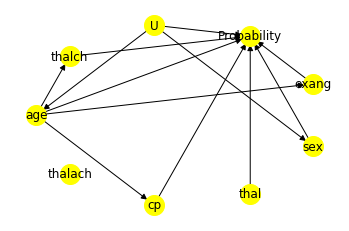

In [13]:
# With graph
model=CausalModel(
        data = df,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [14]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                              
──────(Expectation(Probability|thalach,sex,thal))
d[age]                                           
Estimand assumption 1, Unconfoundedness: If U→{age} and U→Probability then P(Probability|age,thalach,sex,thal,U) = P(Probability|age,thalach,sex,thal)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [15]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                              
──────(Expectation(Probability|thalach,sex,thal))
d[age]                                           
Estimand assumption 1, Unconfoundedness: If U→{age} and U→Probability then P(Probability|age,thalach,sex,thal,U) = P(Probability|age,thalach,sex,thal)

## Realized estimand
b: Probability~age+thalach+sex+thal
Target units: ate

## Estimate
Mean value: -0.07749855336814318

Causal Estimate is -0.07749855336814318


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [16]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:-0.07749855336814318
New effect:-0.07192921598671795



# Replace Treatment with Placebo

In [17]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:-0.07749855336814318
New effect:0.00024737509780125915
p value:0.47



# Remove Random Subset of Data

In [18]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:-0.07749855336814318
New effect:-0.08623841608966153
p value:0.33999999999999997

